[write_ups](https://github.com/tamzeed-toha/Nonlinear_and_Data_Driven_Estimation/blob/main/write_ups/project_write_ups.pdf)

# Nonlinear observability and estimation


this notebook contains non-linear observability analysis of my model. which is a planer drone with unknown control parameters. then with an observable model, different estimation techniques are applied to estimate the unknown parameters.

In [1]:
import numpy as np
import sympy as sp
import sys
import matplotlib.pyplot as plt
from pprint import pprint
import scipy
from scipy.integrate import odeint
import matplotlib.colors as mcolors

sys.path.append('../Utility')
import symbolic_derivatives
from plot_utility import plot_tme
from emperical_observability import *

sp.init_printing()

%load_ext autoreload
%autoreload 2

# Observability analysis of the model

## states and dynamics

In [2]:
theta_dot, theta, x_dot, x, z_dot, z, beta1, beta2 = sp.symbols(r'\dot{\theta} \theta \dot{x} x \dot{z} z \beta_1 \beta_2')
x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8 = sp.symbols('x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8')
g = sp.symbols('g')

state = sp.Matrix([theta_dot, theta, x_dot, x, z_dot, z, beta1, beta2, ])
# state_x = sp.Matrix([x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, ])

f_0 = sp.Matrix([0, theta_dot, 0, x_dot, -g, z_dot, 0, 0, ])
f_1 = sp.Matrix([0, 0, beta2, 0, beta2, 0, 0, 0, ])
f_2 = sp.Matrix([beta1, 0, 0, 0, 0, 0, 0, 0, ])

def sub_by_dict(expr, sub_dict):
    for key, value in sub_dict.items():
        expr = expr.subs(key, value)
    return expr

# state_relation = {theta_dot: x_2, theta: x_1, x_dot: x_4, x: x_3, z_dot: x_6, z: x_5, beta1: x_7, beta2: x_8, g: 9.81}
state_relation = {theta_dot: x_1, theta: x_2, x_dot: x_3, x: x_4, z_dot: x_5, z: x_6, beta1: x_7, beta2: x_8, g: 9.81}
state_x = sub_by_dict(state, state_relation)

state, state_x, f_0, f_1, f_2
# state_x, sub_by_dict(f_0, state_relation), sub_by_dict(f_1, state_relation), sub_by_dict(f_2, state_relation)

⎛⎡\dot{\theta}⎤  ⎡x₁⎤  ⎡     0      ⎤  ⎡  0   ⎤  ⎡\beta₁⎤⎞
⎜⎢            ⎥  ⎢  ⎥  ⎢            ⎥  ⎢      ⎥  ⎢      ⎥⎟
⎜⎢   \theta   ⎥  ⎢x₂⎥  ⎢\dot{\theta}⎥  ⎢  0   ⎥  ⎢  0   ⎥⎟
⎜⎢            ⎥  ⎢  ⎥  ⎢            ⎥  ⎢      ⎥  ⎢      ⎥⎟
⎜⎢  \dot{x}   ⎥  ⎢x₃⎥  ⎢     0      ⎥  ⎢\beta₂⎥  ⎢  0   ⎥⎟
⎜⎢            ⎥  ⎢  ⎥  ⎢            ⎥  ⎢      ⎥  ⎢      ⎥⎟
⎜⎢     x      ⎥  ⎢x₄⎥  ⎢  \dot{x}   ⎥  ⎢  0   ⎥  ⎢  0   ⎥⎟
⎜⎢            ⎥, ⎢  ⎥, ⎢            ⎥, ⎢      ⎥, ⎢      ⎥⎟
⎜⎢  \dot{z}   ⎥  ⎢x₅⎥  ⎢     -g     ⎥  ⎢\beta₂⎥  ⎢  0   ⎥⎟
⎜⎢            ⎥  ⎢  ⎥  ⎢            ⎥  ⎢      ⎥  ⎢      ⎥⎟
⎜⎢     z      ⎥  ⎢x₆⎥  ⎢  \dot{z}   ⎥  ⎢  0   ⎥  ⎢  0   ⎥⎟
⎜⎢            ⎥  ⎢  ⎥  ⎢            ⎥  ⎢      ⎥  ⎢      ⎥⎟
⎜⎢   \beta₁   ⎥  ⎢x₇⎥  ⎢     0      ⎥  ⎢  0   ⎥  ⎢  0   ⎥⎟
⎜⎢            ⎥  ⎢  ⎥  ⎢            ⎥  ⎢      ⎥  ⎢      ⎥⎟
⎝⎣   \beta₂   ⎦  ⎣x₈⎦  ⎣     0      ⎦  ⎣  0   ⎦  ⎣  0   ⎦⎠

## measurements:

In [82]:

h0 = state                  # essentially all states are directly measured
h1 = sp.Matrix([theta, x, z])  # only theta, x, and z are measured
h2 = sp.Matrix([theta, x])  # only theta and x are measured
h3 = sp.Matrix([theta*x*z])  # only theta and z are measured
h4 = sp.Matrix([theta, x*z])      # only x and z are measured
h5 = sp.Matrix([theta, x+z, z])  # theta, x+z, and z are measured
h6 = sp.Matrix([theta+x, z+x])  # theta+x, z+x, and z are measured 
h7 = sp.Matrix([theta+x, x+z, z+theta])  # theta+x, x+z, and z+theta are measured
h8 = sp.Matrix([theta*x, z/x, theta+z])  # theta*x, z/x, and theta+z are measured
h9 = sp.Matrix([theta*x, z/x,])  # theta*x, z/x, and theta+z are measured\
h10 = sp.Matrix([theta_dot, x_dot, z_dot])  # theta_dot, x_dot, and z_dot are measured
h11 = sp.Matrix([theta_dot, theta, x_dot, z_dot])  # theta_dot, theta, x_dot, and z_dot are measured
h12 = sp.Matrix([theta_dot, sp.log(theta), x_dot, z_dot])  # theta_dot, log(theta), x_dot, and z_dot are measured
h13 = sp.Matrix([theta_dot, theta, x_dot, z_dot, x, z])  # theta_dot, theta, x_dot, z_dot, x, and z are measured

universal_h = {"h0": h0, "h1": h1, "h2": h2, "h3": h3, "h4": h4, "h5": h5, "h6": h6, "h7": h7, "h8": h8, "h9": h9, "h10": h10, "h11": h11, "h12": h12, "h13": h13}

class MeasurementCollection:
    def __init__(self, ids) -> None:
        global universal_h
        self.universal_h = universal_h
        h_collection = []
        h_funcs = []
        
        def wrap(func, h):
            def wrapper(x):
                return func(x, h)
            return wrapper
        
        for id in ids.split(","):
            id = id.strip()
            h_collection.append(universal_h[id])
            if getattr(self, f"func_{id}", None) is None:
                h_funcs.append(wrap(self.func_general, universal_h[id]))
            else:
                h_funcs.append(getattr(self, f"func_{id}"))
        self.h_collection = h_collection
        self.h_funcs = h_funcs
        
    def measure(self, x, h):
        id = self.h_collection.index(h)
        return self.h_funcs[id](x)
    
    @staticmethod
    def func_general(x, h):
        h = sub_by_dict(h, state_relation)
        afunc = lambda xx: h.subs({x_1: xx[0], x_2: xx[1], x_3: xx[2], x_4: xx[3], x_5: xx[4], x_6: xx[5], x_7: xx[6], x_8: xx[7]})
        return np.array([afunc(xx) for xx in x]).reshape(-1, len(h))
    @staticmethod
    def func_h0(x):
        x = np.atleast_2d(x)
        return np.array(x)
    @staticmethod
    def func_h1(x):
        x = np.atleast_2d(x)
        return np.array([x[:,1], x[:,3], x[:,5]]).T
    @staticmethod
    def func_h2(x):
        x = np.atleast_2d(x)
        return np.array([x[:,1], x[:,3]]).T
    @staticmethod
    def func_h3(x):
        x = np.atleast_2d(x)
        return np.array([x[:,1]*x[:,3]*x[:,5]]).T
    @staticmethod
    def func_h4(x):
        x = np.atleast_2d(x)
        return np.array([x[:,1], x[:,3]*x[:,5]]).T
    @staticmethod
    def func_h5(x):
        x = np.atleast_2d(x)
        return np.array([x[:,1], x[:,3]+x[:,5], x[:,5]]).T
    @staticmethod
    def func_h6(x):
        x = np.atleast_2d(x)
        return np.array([x[:,1]+x[:,3], x[:,5]+x[:,3]]).T
    @staticmethod
    def func_h7(x):
        x = np.atleast_2d(x)
        return np.array([x[:,1]+x[:,3], x[:,3]+x[:,5], x[:,5]+x[:,1]]).T
    @staticmethod
    def func_h8(x):
        x = np.atleast_2d(x) + 1e-10
        return np.array([x[:,1]*x[:,3], x[:,5]/x[:,3], x[:,1]+x[:,5]]).T
    @staticmethod
    def func_h9(x):
        x = np.atleast_2d(x) + 1e-10
        return np.array([x[:,1]*x[:,3], x[:,5]/x[:,3]]).T
    @staticmethod
    def func_h10(x):
        x = np.atleast_2d(x)
        return np.array([x[:,0], x[:,2], x[:,4]]).T
    @staticmethod
    def func_h11(x):
        x = np.atleast_2d(x)
        return np.array([x[:,0], x[:,1], x[:,2], x[:,4]]).T
    @staticmethod
    def func_h12(x):
        x = np.atleast_2d(x)
        return np.array([x[:,0], np.log(x[:,1]), x[:,2], x[:,4]]).T
    @staticmethod
    def func_h13(x):
        x = np.atleast_2d(x)
        return np.array([x[:,0], x[:,1], x[:,2], x[:,4], x[:,3], x[:,5]]).T


# h_collection = [h0, h1, h2, h3, h4, h5, h6, h7, h8, h9, h10]
# h_collection

h_choice = "h0, h1, h2, h3, h4, h5, h6, h7, h8, h9, h10, h11, h12, h13"

my_measurements = MeasurementCollection(h_choice)
h_collection = my_measurements.h_collection

h_collection
# [sub_by_dict(h, state_relation) for h in h_collection]
# my_measurements.h_funcs[-1](np.array([[1,2,3,4,5,6,7,8],[1,2,3,4,5,6,7,8]]))
# my_measurements.h_funcs[-2](np.array([1,2,3,4,5,6,7,8]))

⎡⎡\dot{\theta}⎤                                                               
⎢⎢            ⎥                                                               
⎢⎢   \theta   ⎥                                                               
⎢⎢            ⎥                                                               
⎢⎢  \dot{x}   ⎥                                                               
⎢⎢            ⎥  ⎡\theta⎤                                    ⎡\theta⎤         
⎢⎢     x      ⎥  ⎢      ⎥  ⎡\theta⎤                ⎡\theta⎤  ⎢      ⎥  ⎡\theta
⎢⎢            ⎥, ⎢  x   ⎥, ⎢      ⎥, [\theta⋅x⋅z], ⎢      ⎥, ⎢x + z ⎥, ⎢      
⎢⎢  \dot{z}   ⎥  ⎢      ⎥  ⎣  x   ⎦                ⎣ x⋅z  ⎦  ⎢      ⎥  ⎣  x + 
⎢⎢            ⎥  ⎣  z   ⎦                                    ⎣  z   ⎦         
⎢⎢     z      ⎥                                                               
⎢⎢            ⎥                                                               
⎢⎢   \beta₁   ⎥                                     

## G and O matrix

In [4]:

g_first_order = []
G_collection = []
O_collection = []
first_order_bigO = []
for h in h_collection:
    g1 = symbolic_derivatives.get_bigO(h, state, [f_0, f_1, f_2])
    g2 = symbolic_derivatives.get_bigO(sp.Matrix.vstack(*g1), state, [f_0, f_1, f_2])
    # take only unique rows
    g1 = set(sp.Matrix.vstack(*g1))
    g2 = set(sp.Matrix.vstack(*g2))

    G = sp.Matrix(list(g1.union(g2)))    
    g1 = sp.Matrix(list(g1))   ## for comparing first order and second orders
    O = G.jacobian(state)
    
    g_first_order.append(g1)
    G_collection.append(G)
    O_collection.append(O)
    first_order_bigO.append(g1.jacobian(state))

G_collection
O_collection
# [sub_by_dict(g, state_relation) for g in g_first_order]

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢⎡0  0  0  0  0  0  0  0⎤  ⎡0  0  0  0  0  0  0  0⎤ 

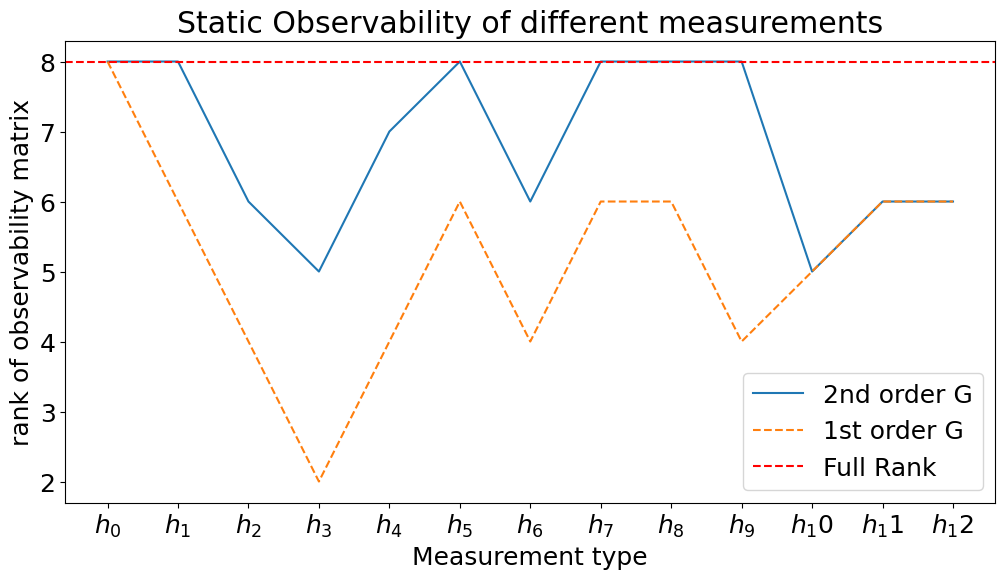

In [16]:
# check observability of every kind of measurement
ranks = [O.rank() for O in O_collection]
first_order_ranks = [O.rank() for O in first_order_bigO]
plt.figure(figsize=(12, 6))
plt.plot(ranks, label="2nd order G")
plt.plot(first_order_ranks, label="1st order G", ls='--')
plt.axhline(y=state.shape[0], color='r', linestyle='--', label='Full Rank')
plt.xticks(range(len(h_collection)), labels=[r'$h_{}$'.format(i) for i in range(len(h_collection))] )
plt.legend()
plt.title('Static Observability of different measurements')
plt.ylabel('rank of observability matrix')
plt.xlabel('Measurement type')
# plt.show()
plt.savefig('../write_ups/figures/analytical_observability.png', dpi=300)

obviously, the model is more observable when if we use second derivative of G.
\
\
generally, to make the model observable we need atleast 3 measurements (each for every degree of freedom).
\
\
but observability might also depend on state values. to check that we can use the above method on a simulated 2d drone model given a set of trajectories.

# data simulation

In [17]:
import scipy.integrate


class planer_drone():
    def __init__(self):
        self.m = 0.5 # mass
        self.l = 0.2 # distance from rotor to COM
        self.I = 2/5*self.m*self.l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
        self.g = 9.81 # gravity constant

        # Control Parameters
        self.tau_k_theta = 100 # torque control to stabilize theta
        self.tau_k_thetadot = 200 # torque control to provide thetadot damping
        self.tau_k_x = .01 # torque control to control x position
        self.tau_k_xdot = .2 # torque control to provide xdot damping
        self.F_k_z = 1000 # Force control to control z position
        self.F_k_zdot = 10000 # Force control to control z position
        self.F0 = self.m * self.g
        
    def control(self, X, t, desired_trajectory):
        # thetadot, theta, xdot, x, zdot, z = np.ravel(X)
        thetadot, theta, xdot, x, zdot, z, beta1, beta2 = np.ravel(X)
        
        # desired trajectory
        if callable(desired_trajectory):
            time = t
            theta_des, x_des, z_des = desired_trajectory(t)
        elif isinstance(desired_trajectory, tuple):
            time, theta_des, x_des, z_des = desired_trajectory
        elif isinstance(desired_trajectory, np.ndarray):
            time, theta_des, x_des, z_des = desired_trajectory.T
        else:
            raise ValueError("desired_trajectory must be a callable function or a tuple")
        
        theta_des = np.interp(t, time, theta_des)
        x_des = np.interp(t, time, x_des)
        z_des = np.interp(t, time, z_des)
        
        # error
        theta_err = theta_des - theta
        x_err = x_des - x
        z_err = z_des - z
        
        # control
        # tau = -(self.tau_k_x*x_err - self.tau_k_xdot*xdot)  + (self.tau_k_theta*(-theta) - self.tau_k_thetadot*thetadot)
        # F = (self.F_k_z*z_err - self.F_k_zdot*zdot)
        tau = -(self.tau_k_x*x_err - self.tau_k_xdot*xdot)  + (self.tau_k_theta*(theta_err) - self.tau_k_thetadot*thetadot)
        F = (self.F_k_z*z_err - self.F_k_zdot*zdot)
        
        F = np.clip(F, 0, 1.2*self.F0)
        tau = np.clip(tau, -1.2*self.F0, 1.2*self.F0)
        return F, tau
    
    def f(self, X, t, desired_trajectory, invert=False):
        if not invert:
            # thetadot, theta, xdot, x, zdot, z = np.ravel(X)
            thetadot, theta, xdot, x, zdot, z, beta1, beta2 = np.ravel(X)
        else:
            tt = t
            t = X
            X = tt
            thetadot, theta, xdot, x, zdot, z, beta1, beta2 = np.ravel(X)
        
        # control
        F, tau = self.control(X, t, desired_trajectory)
        # F = F + np.random.normal(0, .001)
        # tau = tau + np.random.normal(0, 0.0001)
        
        m = 1/beta2
        I = 1/beta1
        
        # dynamics
        d_theta = thetadot
        d_thetadot = tau/I
        d_x = xdot
        d_xdot = -F*np.sin(theta)/m
        d_z = zdot
        d_zdot = (F*np.cos(theta)-m*self.g)/m
        
        # d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
        d_x = [d_thetadot, d_theta, d_xdot, d_x, d_zdot, d_z, 0, 0]
        
        return d_x
        
    
    # def f_u(self, X, t, u):
    def f_u(self, t,X, _):
        # works with scipy.integrate.solve_ivp, takes input u instead of desired_trajectory
        # thetadot, theta, xdot, x, zdot, z = np.ravel(X)
        thetadot, theta, xdot, x, zdot, z, beta1, beta2 = np.ravel(X)
        
        # control
        global U
        u = U.copy()
        tsim = u[:,0]
        Fvals = u[:,1]
        tauvals = u[:,2]
            
        F = np.interp(t, tsim, Fvals)
        tau = np.interp(t, tsim, tauvals)
        
        m = 1/beta2
        I = 1/beta1
        
        # dynamics
        d_theta = thetadot
        d_thetadot = tau/I
        d_x = xdot
        d_xdot = -F*np.sin(theta)/m
        d_z = zdot
        d_zdot = (F*np.cos(theta)-m*self.g)/m
        
        # d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
        d_x = [d_thetadot, d_theta, d_xdot, d_x, d_zdot, d_z, 0, 0]
        
        return d_x
    
    def simulate(self, x0, tsim, desired_trajectory, h, state_symbolic):
        result = odeint(self.f, x0, tsim, args=(desired_trajectory,))
        x = result
        
        # afunc = lambda i: h.subs(list(zip(state_symbolic, x[:,i])))
        # y = np.array(list(map(afunc, range(x.shape[1])))).T
        # y = np.atleast_2d(y)
        # y = y.reshape(-1, y.shape[-1])
        
        global my_measurements
        y = my_measurements.measure(x, h)
        
        # u = np.array([self.control(x[:,i], tsim[i], desired_trajectory) for i in range(x.shape[0])])
        u = np.array([self.control(x[i], tsim[i], desired_trajectory) for i in range(x.shape[0])])
        u = np.atleast_2d(u)
        return x, y, u
    
    def simulate_from_input(self, x0, tsim, u, h, state_symbolic):
        # result = odeint(self.f_u, x0, tsim, args=(u,))
        result = scipy.integrate.solve_ivp(self.f_u, (tsim[0], tsim[-1]), x0, t_eval=tsim, args=(u,))
        x = result.y.T
        
        # afunc = lambda i: h.subs(list(zip(state_symbolic, x[:,i])))
        # y = np.array(list(map(afunc, range(x.shape[1])))).T
        # y = np.atleast_2d(y)
        # y = y.reshape(-1, y.shape[-1])
        
        global my_measurements
        y = my_measurements.measure(x, h)
        u = u[:,1:]
        
        return x, y, u

## trajectories

In [18]:
def sinusoidal_x(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.05*t)
    return theta_des, x_des, z_des

def sinusoidal_xz(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.sin(0.05*t)
    x_des = 1*np.cos(0.05*t)
    return theta_des, x_des, z_des

def random_xz(t):
    theta_des = 0*np.ones_like(t)
    z_des = np.ones_like(t)
    x_des = np.random.normal(0, 0.1, np.array(t).shape)
    return theta_des, x_des, z_des

def noisy_sinusoidal_x(t):
    theta_des = 0*np.ones_like(t) + np.random.normal(0, 0.001, np.array(t).shape)
    z_des = 10*np.ones_like(t) + np.random.normal(0, 2, np.array(t).shape)
    x_des = np.sin(0.05*t) + np.random.normal(0, 10, np.array(t).shape)
    return theta_des, x_des, z_des

trajectories = {
                    "sinusoidal_x" : sinusoidal_x,
                    "sinusoidal_xz" : sinusoidal_xz,
                    # "random_xz" : random_xz,
                    "noisy_sinusoidal_x" : noisy_sinusoidal_x,
                }

## running the simulation:

In [19]:
time = np.arange(0, 1000, 1)
drone = planer_drone()
xx0 = np.vstack([*np.random.rand(6), 1/drone.I, 1/drone.m]).reshape(-1)
print(f"==>> initial condition: {xx0}")
simulated_states = {}
# simulated_measurements = {}
trajectory_values = {}
for trajectory_name, trajectory in trajectories.items():
    trajectory_value = np.vstack([time, np.array(trajectory(time))]).T
    print(f"==>> Simulating {trajectory_name}")
    # result = odeint(drone.f, xx0, time, args=(trajectory,), full_output=0)
    result = odeint(drone.f, xx0, time, args=(trajectory_value,), full_output=0)
    # result = scipy.integrate.solve_ivp(drone.f, (time[0], time[-1]), xx0, t_eval=time, args=(trajectory,True))
    simulated_states[trajectory_name] = result.T
    # simulated_states[trajectory_name] = result.y.T
    trajectory_values[trajectory_name] = trajectory_value

==>> initial condition: [4.17319098e-02 9.40285928e-01 9.09830035e-01 6.49077456e-01
 8.20041031e-01 7.00728042e-01 1.25000000e+02 2.00000000e+00]
==>> Simulating sinusoidal_x
==>> Simulating sinusoidal_xz
==>> Simulating noisy_sinusoidal_x


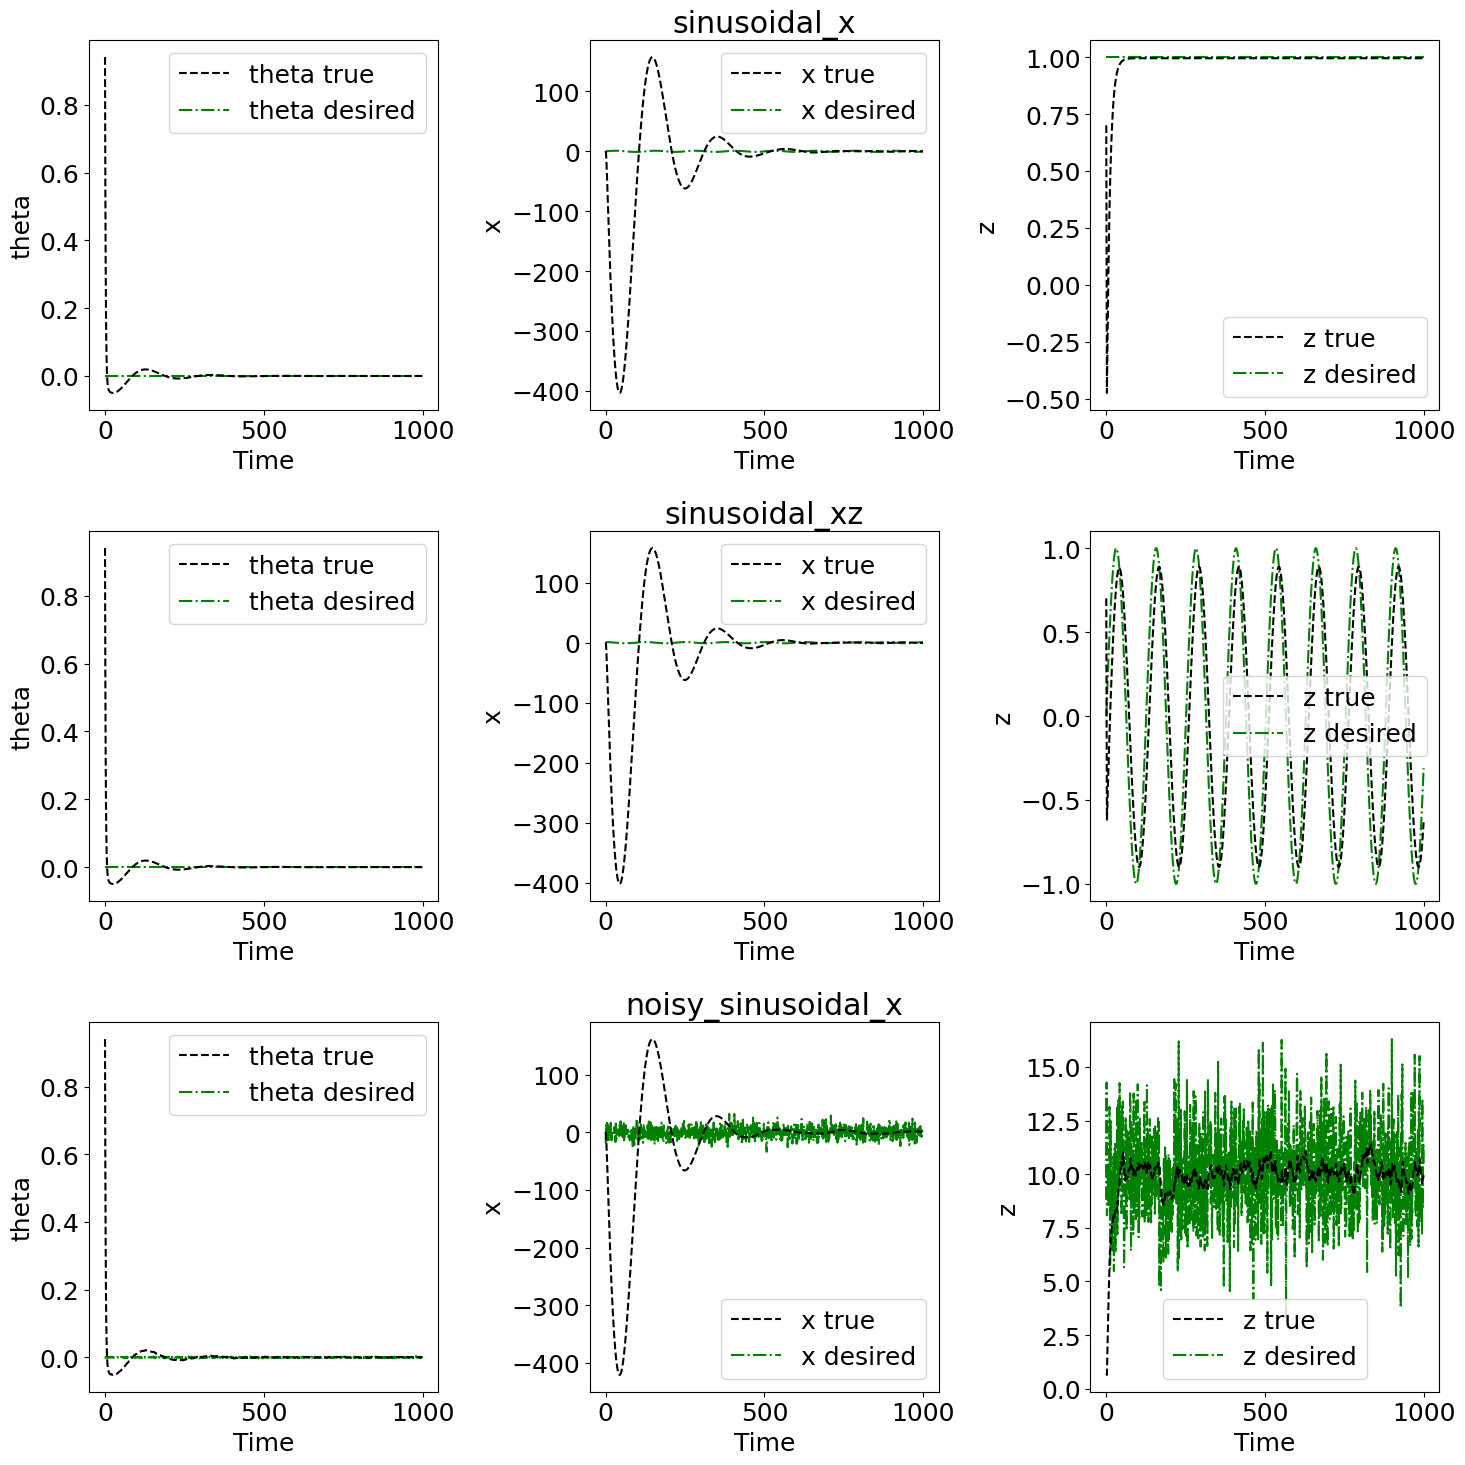

In [20]:
fig, axes = plt.subplots(len(simulated_states), 3, figsize=(15, 5*len(simulated_states)))
axes = (ax for ax in axes.ravel())

for trajectory_name, trajectory in trajectories.items():
    # theta_des, x_des, z_des = trajectory(time)
    _, theta_des, x_des, z_des = trajectory_values[trajectory_name].T
    
    ax = next(axes)
    plot_tme(time, simulated_states[trajectory_name][1], None, ax=ax, label_var='theta', desired=theta_des)
    
    ax = next(axes)
    plot_tme(time, simulated_states[trajectory_name][3], None, ax=ax, label_var='x', desired=x_des)
    ax.set_title(trajectory_name)
    
    ax = next(axes)
    plot_tme(time, simulated_states[trajectory_name][5],None, ax=ax, label_var='z', desired=z_des)
    # ax.set_ylim(-1, 2)
    
fig.tight_layout()
plt.show()


here, every row represents a particular trajectory.
\
\
\
### estimating observability of the model with varied trajectories and measurement matrix
this might take a while

In [21]:
sample_n = 10
sample_points = np.linspace(0, len(time), sample_n, endpoint=False).astype(int)

observability_values = np.zeros((len(simulated_states), len(O_collection), len(sample_points)))
for tr, state_values in simulated_states.items():    # for all trajectories
    for j,bigO in enumerate(O_collection):  # for all observability matrices
        print(f"==> {tr} and h_{j}")
        afunc = lambda i: bigO.subs(dict(zip(state, state_values[:, i]))).rank()
        # def bfunc(i):
        #     val = bigO.subs(dict(zip(state, state_values[:, i])))
        #     return val.rank()
        
        values = np.array(list(map(afunc, sample_points)))
        observability_values[list(trajectories.keys()).index(tr), O_collection.index(bigO)] = values
        

==> sinusoidal_x and h_0
==> sinusoidal_x and h_1
==> sinusoidal_x and h_2
==> sinusoidal_x and h_3
==> sinusoidal_x and h_4
==> sinusoidal_x and h_5
==> sinusoidal_x and h_6
==> sinusoidal_x and h_7
==> sinusoidal_x and h_8
==> sinusoidal_x and h_9
==> sinusoidal_x and h_10
==> sinusoidal_x and h_11
==> sinusoidal_x and h_12
==> sinusoidal_xz and h_0
==> sinusoidal_xz and h_1
==> sinusoidal_xz and h_2
==> sinusoidal_xz and h_3
==> sinusoidal_xz and h_4
==> sinusoidal_xz and h_5
==> sinusoidal_xz and h_6
==> sinusoidal_xz and h_7
==> sinusoidal_xz and h_8
==> sinusoidal_xz and h_9
==> sinusoidal_xz and h_10
==> sinusoidal_xz and h_11
==> sinusoidal_xz and h_12
==> noisy_sinusoidal_x and h_0
==> noisy_sinusoidal_x and h_1
==> noisy_sinusoidal_x and h_2
==> noisy_sinusoidal_x and h_3
==> noisy_sinusoidal_x and h_4
==> noisy_sinusoidal_x and h_5
==> noisy_sinusoidal_x and h_6
==> noisy_sinusoidal_x and h_7
==> noisy_sinusoidal_x and h_8
==> noisy_sinusoidal_x and h_9
==> noisy_sinusoidal_

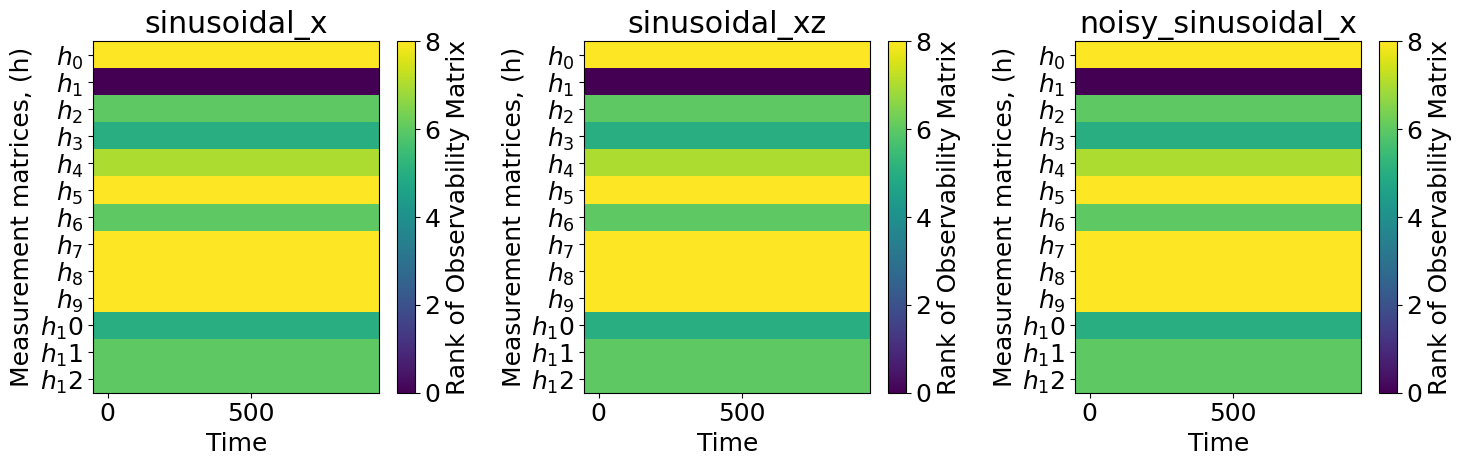

In [27]:
fig, axes = plt.subplots(1, len(trajectories), figsize=(5*len(trajectories),5))
axes = (ax for ax in np.atleast_2d(axes).ravel())

for i, tr in enumerate(trajectories):
    ax = next(axes)
    k = ax.pcolormesh(time[sample_points], range(len(O_collection)),np.flip(observability_values[i]), shading='auto', cmap='viridis')
    colorbar = plt.colorbar(k, ax=ax)
    ax.set_title(tr)
    ax.set_ylabel("Measurement matrices, (h)")
    ax.set_xlabel("Time")
    ax.set_yticks(range(len(O_collection)), labels=[r'$h_{}$'.format(i) for i in range(len(O_collection))][::-1] )
    colorbar.set_label("Rank of Observability Matrix")
    
    
fig.tight_layout()
fig.savefig('../write_ups/figures/observability_with_time.png', dpi=300)

for current model and measurement function (h), observability does not change with time. I may have to change the model or measurement function to something eles so that the system's observability is time variant. it would make the analysis more interesting
\
\
\
one thing to note here: for some reason, the rank of observability matrix for the last few measurements does not match with the rank calculated directly (static observability of different measurements). 

In [89]:
# Emperical observability analysis
drone = planer_drone()
sampling_n = 10
window_size = 10

h_to_use = h13

x0 = np.vstack([*np.random.rand(6), 1/drone.I, 1/drone.m]).reshape(-1)
sim_time = np.linspace(0, 1000, 1000)

trajectory_value = np.vstack([sim_time, np.array(noisy_sinusoidal_x(sim_time))]).T
args = (trajectory_value, h_to_use, state)
state_value, output_y, u = drone.simulate(x0, sim_time, *args)
U = np.vstack([sim_time, u[:,0], u[:,1]]).T

# U = np.vstack([sim_time, np.sin(0.05*sim_time) + 2, np.sin(0.005*sim_time)]).T
# result = scipy.integrate.solve_ivp(drone.f_u, (0, 1000), x0, t_eval=sim_time, args=(0,))
# state_value = result.y.T
print("starting observability analysis")



starting observability analysis


In [90]:


drone = planer_drone()

crb_diags = []
cn_values = []
bigO_mats = []
gramians = []
t0_windows = sim_time[::sampling_n]
window_dx = np.diff(sim_time)[0]
for i,t0_window in enumerate(t0_windows):
    print(f"working on {i}th window of {len(t0_windows)} windows")
    # x0_window = state_value[:, sim_time == t0_window].reshape(-1)
    x0_window = state_value[sim_time == t0_window, :].reshape(-1)
    tsim_window = sim_time[np.logical_and(sim_time >= t0_window, sim_time < t0_window + window_size*window_dx)]

    result = empirical_observability_matrix(drone, x0_window, tsim_window, args=args, eps=1e-6)
    
    # args = (U, h1, state)
    # result = empirical_observability_matrix2(drone, x0_window, tsim_window, args=args, eps=1e-6)
    bigO_mat = result['bigO']
    W = bigO_mat.T @ bigO_mat
    crb_diag = np.diag(np.linalg.inv(W + 1e-1*np.eye(W.shape[0])))
    crb_diags.append(crb_diag)
    bigO_mats.append(bigO_mat)
    gramians.append(W)
    if np.isnan(W).any():
        cn_values.append(np.nan)
    else:
        eig = np.linalg.eigvals(W)
        cn = np.max(eig)/np.min(eig)
        cn_values.append(cn)

    
crb_diags = np.vstack(crb_diags)
bigO_mats = np.vstack(bigO_mats)


working on 0th window of 100 windows
working on 1th window of 100 windows
working on 2th window of 100 windows
working on 3th window of 100 windows
working on 4th window of 100 windows
working on 5th window of 100 windows
working on 6th window of 100 windows
working on 7th window of 100 windows
working on 8th window of 100 windows
working on 9th window of 100 windows
working on 10th window of 100 windows
working on 11th window of 100 windows
working on 12th window of 100 windows
working on 13th window of 100 windows
working on 14th window of 100 windows
working on 15th window of 100 windows
working on 16th window of 100 windows
working on 17th window of 100 windows
working on 18th window of 100 windows
working on 19th window of 100 windows
working on 20th window of 100 windows
working on 21th window of 100 windows
working on 22th window of 100 windows
working on 23th window of 100 windows
working on 24th window of 100 windows
working on 25th window of 100 windows
working on 26th window

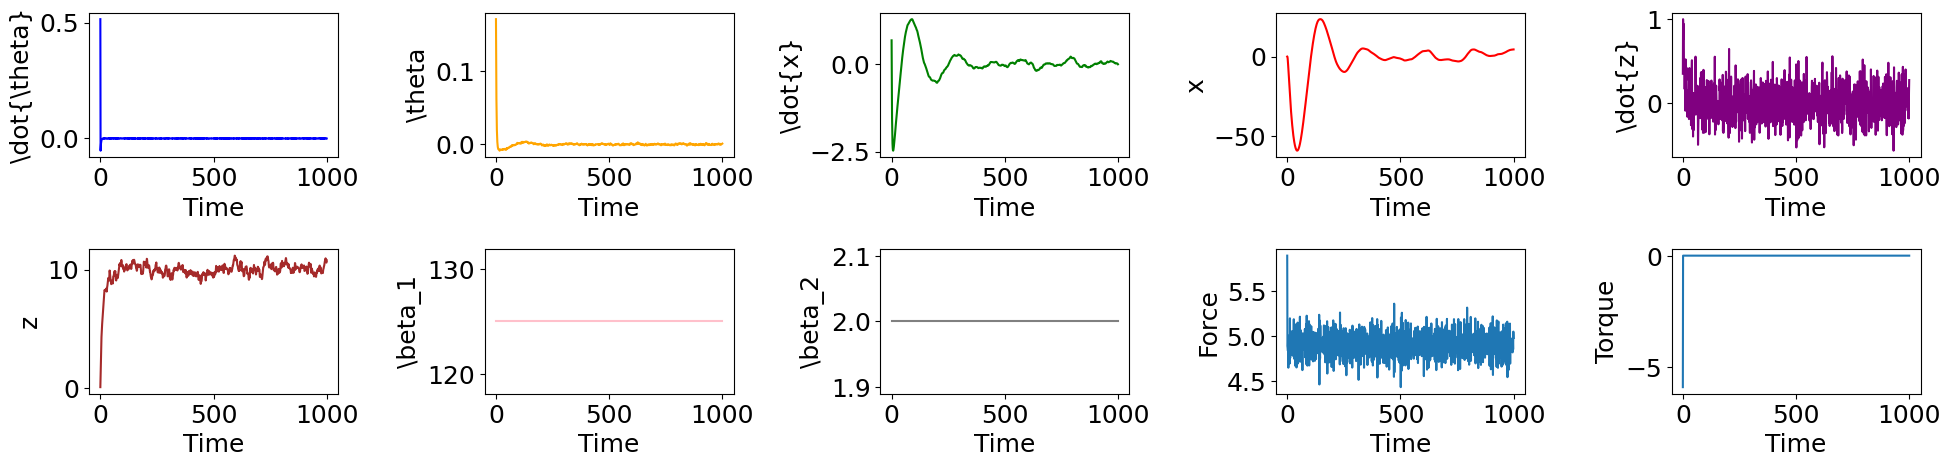

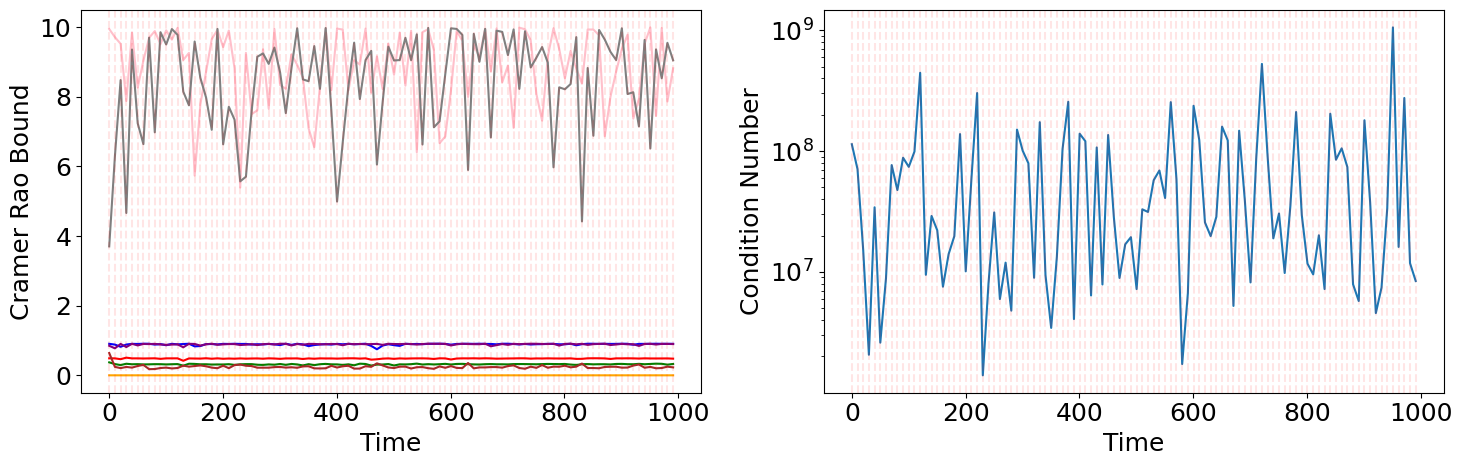

In [91]:

colors = list(mcolors.TABLEAU_COLORS.keys())
colors = [name.split(':')[-1] for name in colors]

fig, axes = plt.subplots(2, state_value.shape[1]//2 + 1, figsize=(20,5))
axes = (ax for ax in axes.ravel())
for i, xval in enumerate(range(state_value.shape[1])):
    ax = next(axes)
    ax.plot(sim_time, state_value[:,xval], label=f"state_{xval}", color=colors[i])
    ax.set_ylabel(state[xval])
    ax.set_xlabel('Time')
ax = next(axes)
ax.plot(sim_time, U[:,1], label='F')
ax.set_ylabel('Force')
ax.set_xlabel('Time')
ax = next(axes)
ax.plot(sim_time, U[:,2], label='tau')
ax.set_ylabel('Torque')
ax.set_xlabel('Time')
fig.tight_layout()
fig.savefig(f'../write_ups/figures/states_with_{trajectory_name}_and_h{h_collection.index(h_to_use)}.png', dpi=300)

fig, [ax,bx] = plt.subplots(1, 2, figsize=(15, 5))

for i, crb_diag in enumerate(crb_diags.T):
    ax.plot(t0_windows, crb_diag, label=f"state_{i}", color=colors[i])
ax.set_ylabel('Cramer Rao Bound')
ax.set_xlabel('Time')

bx.plot(t0_windows, cn_values)
bx.set_ylabel('Condition Number')
bx.set_xlabel('Time')
bx.set_yscale('log')

for t0_window in t0_windows:
    # these are sampling locations, left corner of the window
    ax.axvline(x=t0_window, color='r', linestyle='--', alpha=.1)
    bx.axvline(x=t0_window, color='r', linestyle='--', alpha=.1)

fig.tight_layout()
fig.savefig(f'../write_ups/figures/crb_and_cn_with_{trajectory_name}_and_h{h_collection.index(h_to_use)}.png', dpi=300)

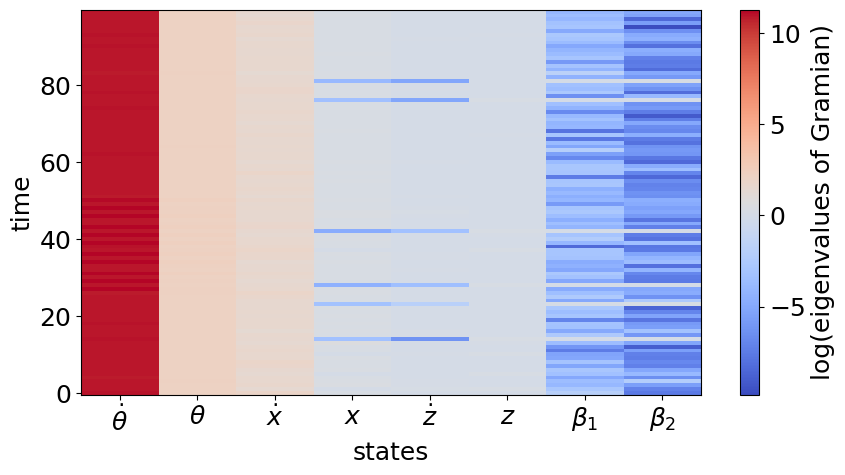

In [93]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# for i, crb_diag in enumerate(crb_diags.T):
#     # ax.pcolormesh(range(len(crb_diag)), t0_windows
#     print(bigO_mat.shape)

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# k = ax.pcolormesh(range(bigO_mats.shape[1]), range(bigO_mats.shape[0]), np.log(bigO_mats), shading='auto', cmap='coolwarm')
# plt.colorbar(k, ax=ax)

# import scipy.linalg


straightend_w = []
for i,w in enumerate(gramians):
    straightend_w.append(np.log(np.linalg.eigvals(w)))
    
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
k = ax.pcolormesh(range(len(state_value.T)), range(len(gramians)), np.vstack(straightend_w), cmap='coolwarm')
kk = plt.colorbar(k, ax=ax)
ax.set_xlabel('states')
ax.set_ylabel('time')
ax.set_xticks(range(len(state_value.T)), labels=[r'${}$'.format(state[i]) for i in range(len(state_value.T))])
kk.set_label('log(eigenvalues of Gramian)')
fig.savefig(f'../write_ups/figures/gramian_eigenvalues_with_{trajectory_name}_and_h{h_collection.index(h_to_use)}.png', dpi=300)

now lets try it on all the trajectories and all different measurement matrices
\
\
this might take a while

Matrix([[\dot{\theta}], [theta], [\dot{x}], [x], [\dot{z}], [z], [beta1], [beta2]])


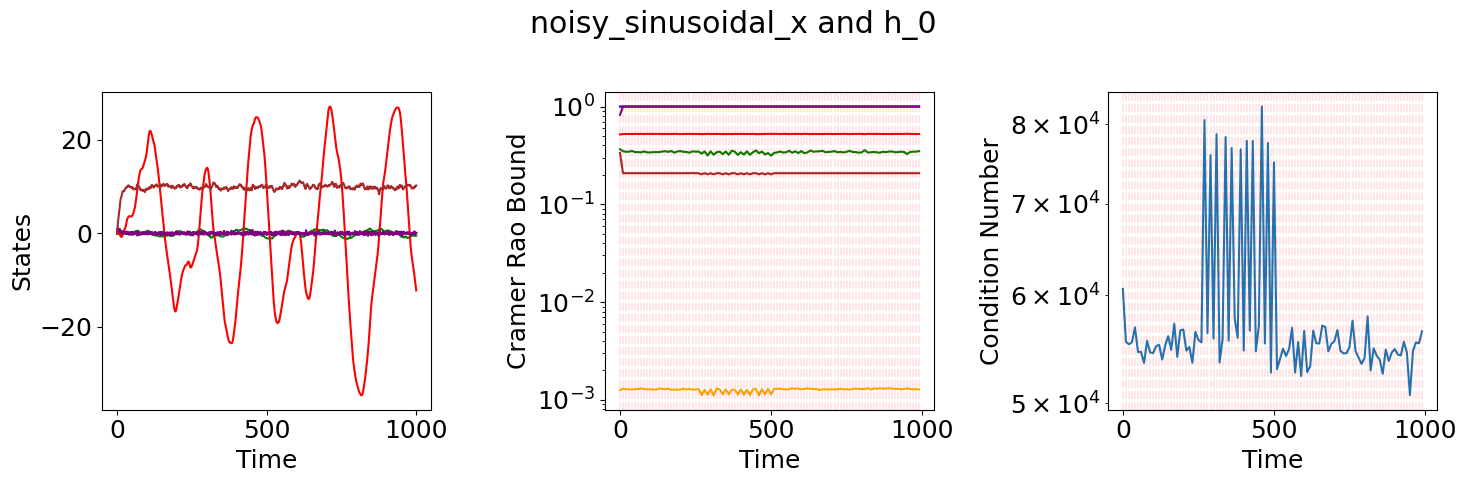

Matrix([[theta], [x], [z]])


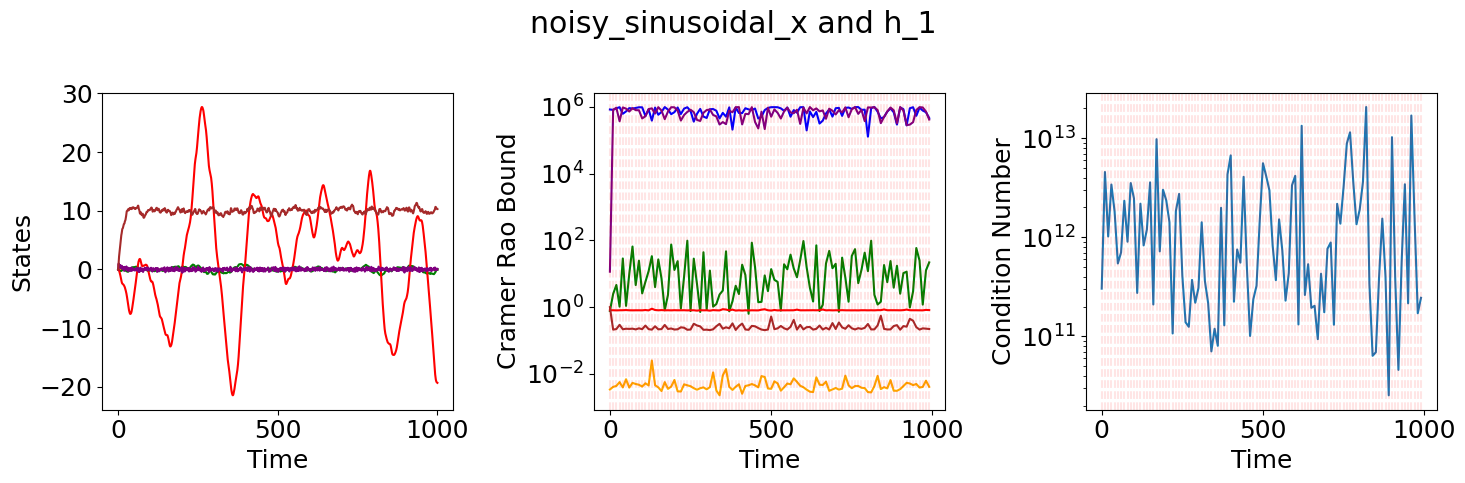

Matrix([[theta], [x]])


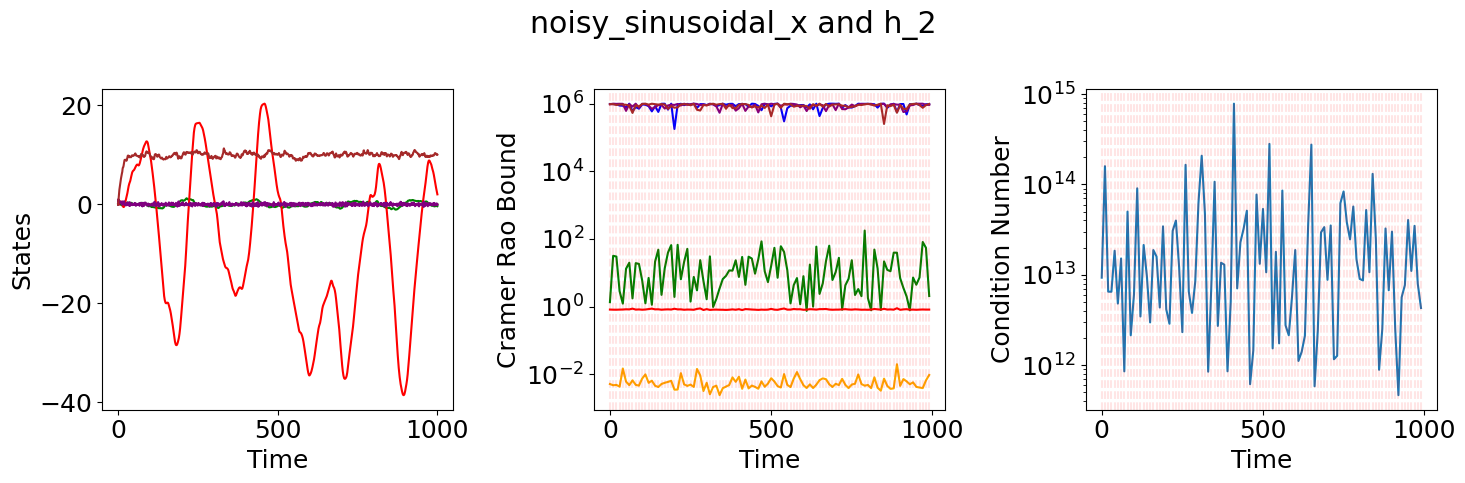

Matrix([[theta*x*z]])


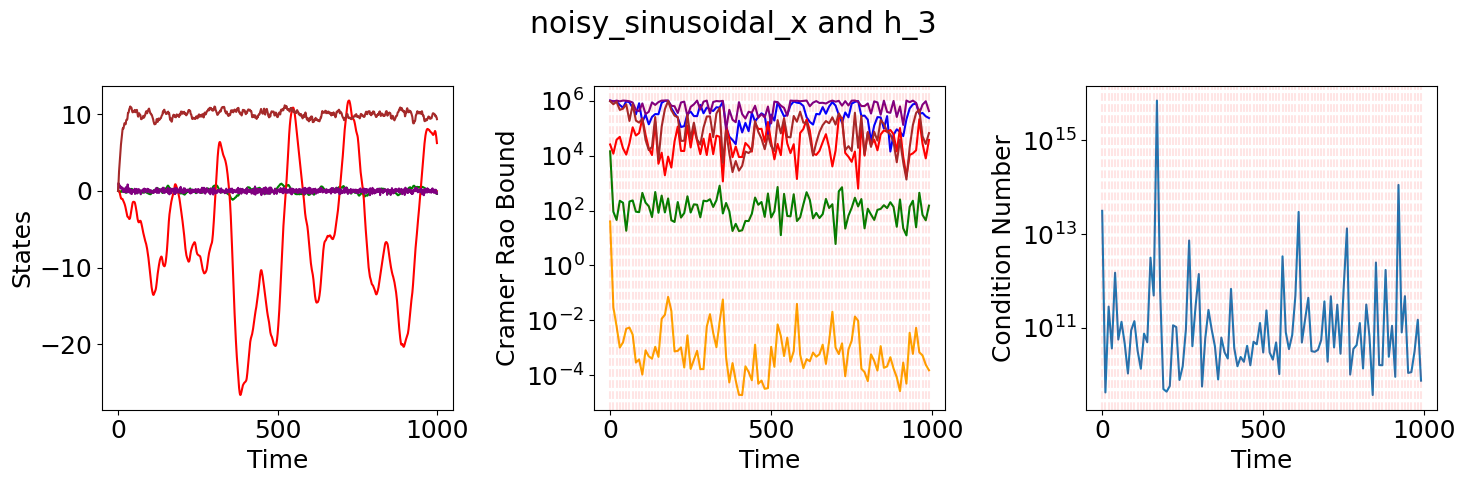

Matrix([[theta], [x*z]])


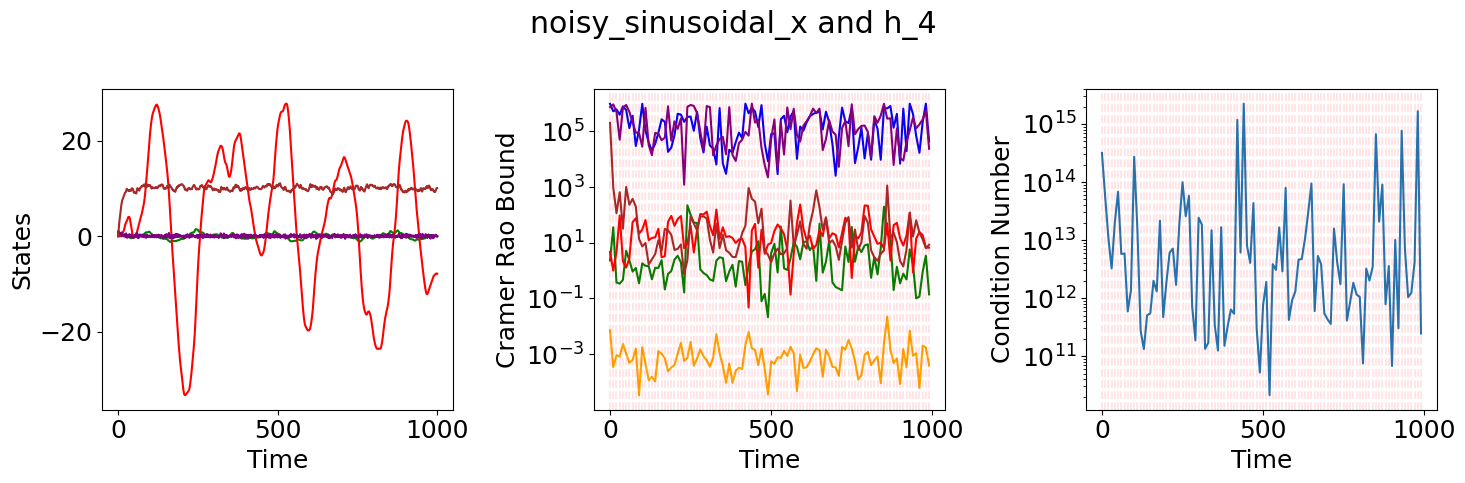

Matrix([[theta], [x + z], [z]])


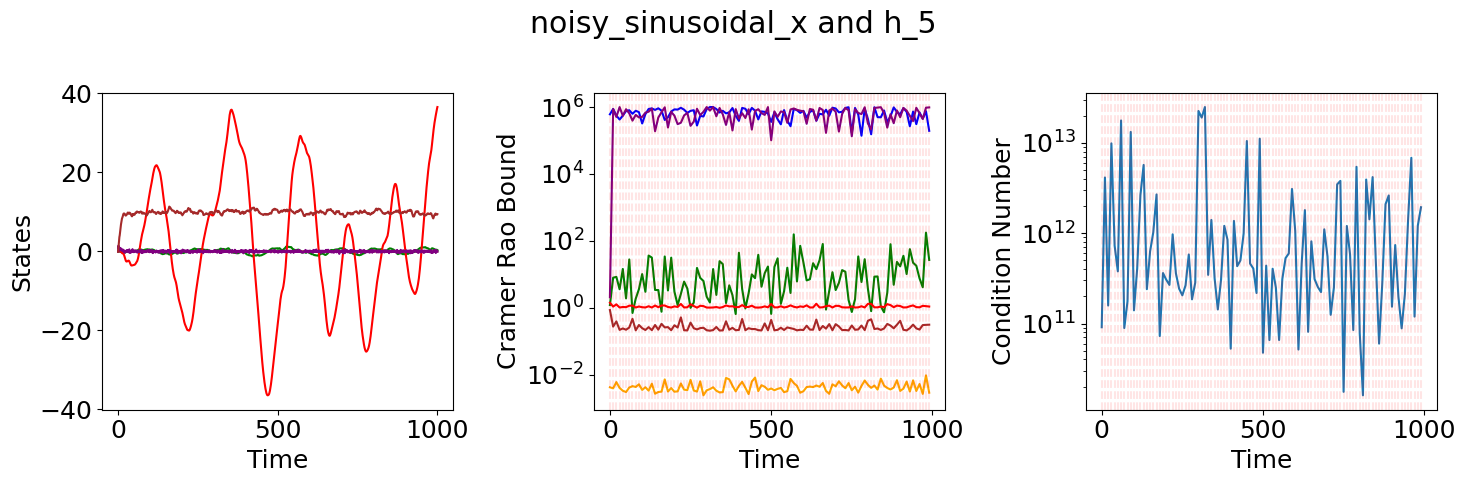

Matrix([[theta + x], [x + z]])


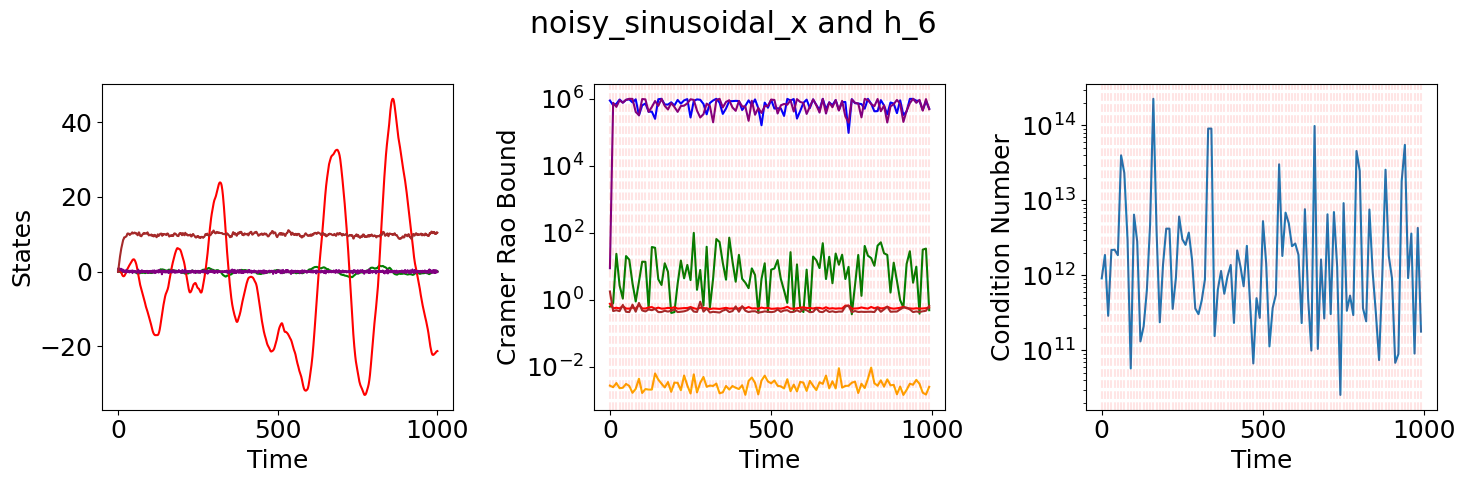

Matrix([[theta + x], [x + z], [theta + z]])


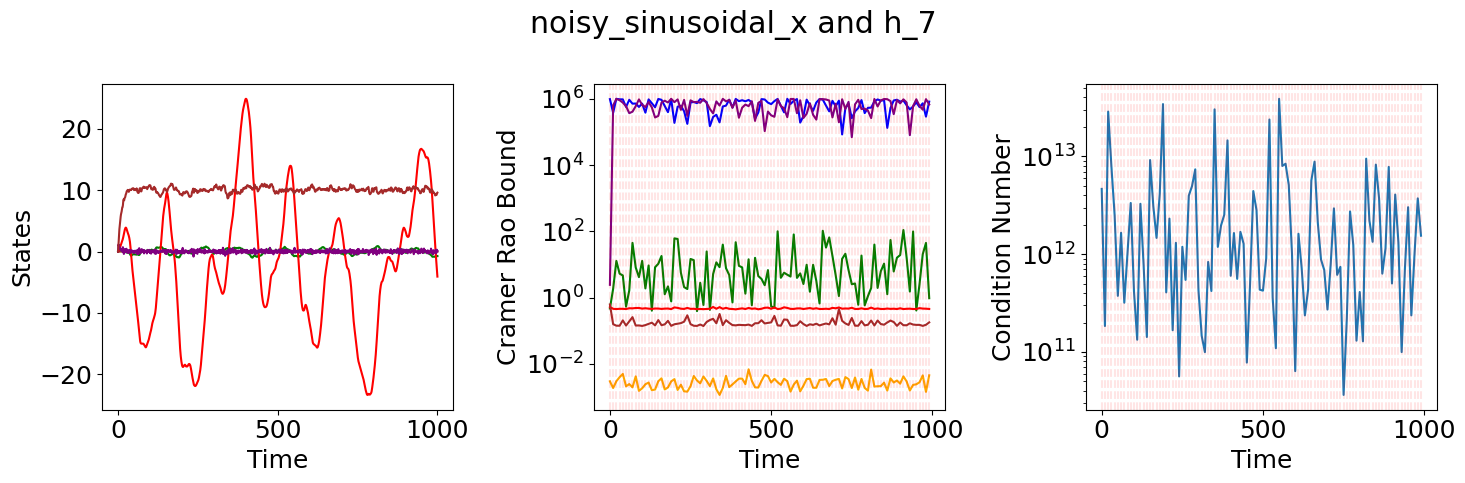

Matrix([[theta*x], [z/x], [theta + z]])


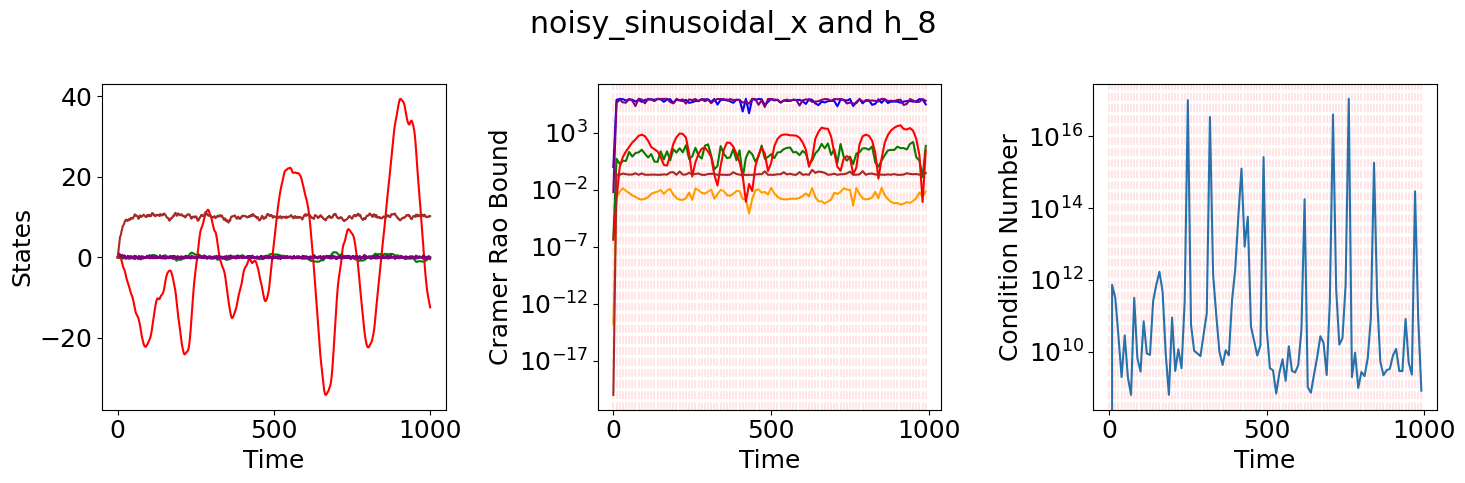

Matrix([[theta*x], [z/x]])


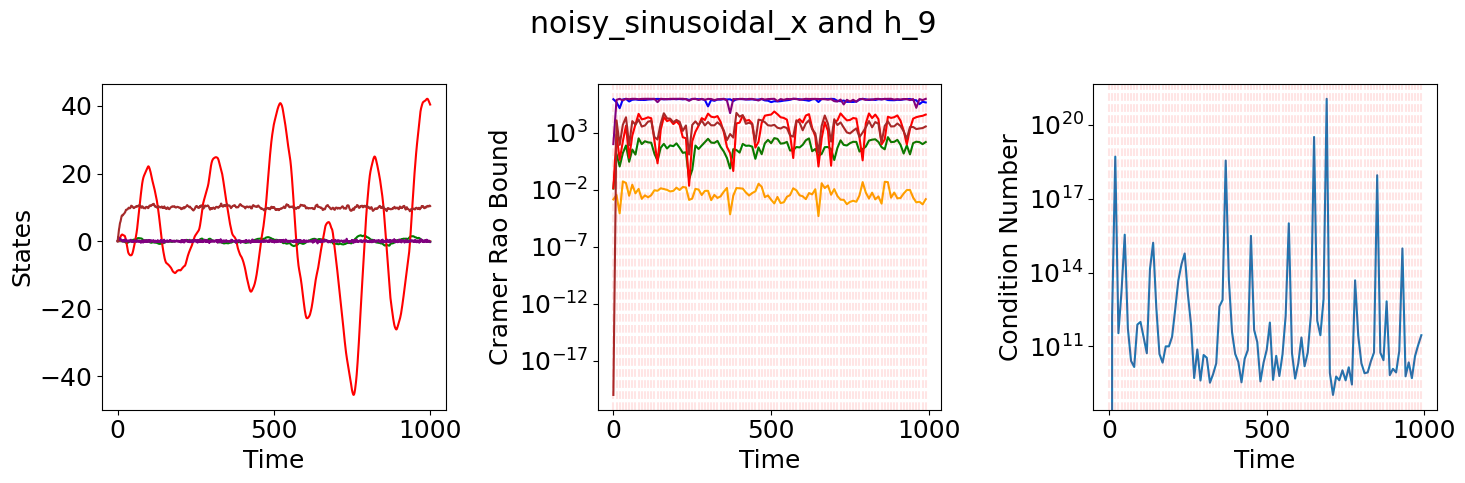

Matrix([[\dot{\theta}], [\dot{x}], [\dot{z}]])


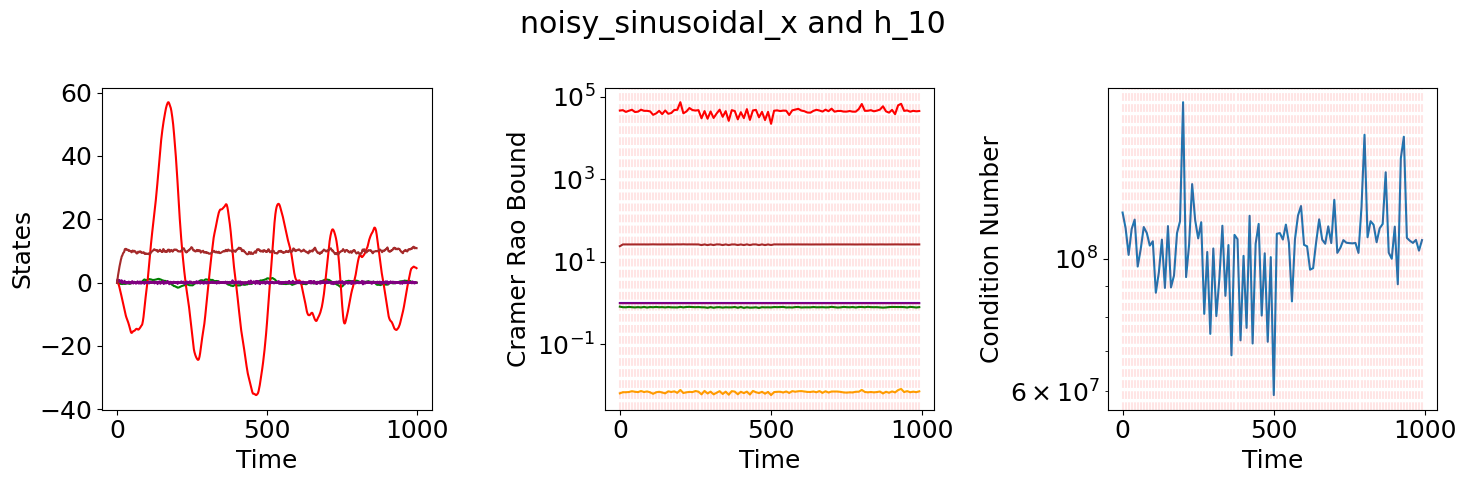

Matrix([[\dot{\theta}], [theta], [\dot{x}], [\dot{z}]])


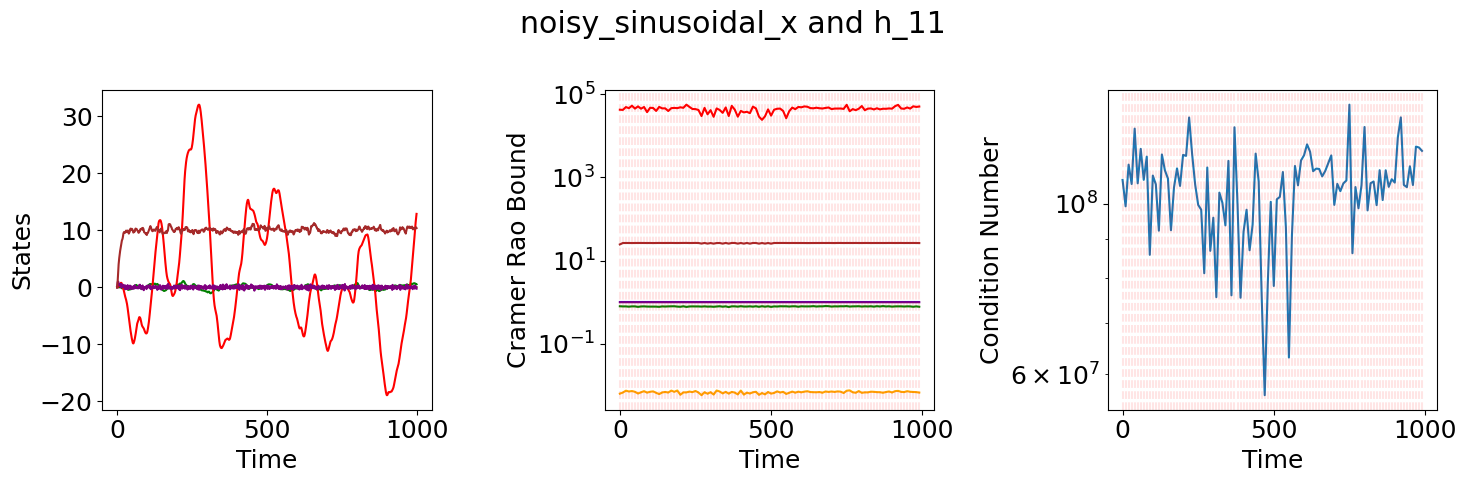

In [134]:
sampling_n = 10
window_size = 10

for i, tr in enumerate(trajectories.values()):
    for j, h in enumerate(h_collection):
        print(h)
        trajectory_value = np.vstack([sim_time, np.array(tr(sim_time))]).T
        # args = (tr, h, state)
        args = (trajectory_value, h, state)
        x0 = np.random.rand(6) * 0
        sim_time = np.linspace(0, 1000, 1000)
        state_value, output_y,_ = drone.simulate(x0, sim_time, *args)

        crb_diags = []
        cn_values = []
        t0_windows = sim_time[::sampling_n]
        window_dx = np.diff(sim_time)[0]
        for t0_window in t0_windows:
            x0_window = state_value[sim_time == t0_window, :].reshape(-1)
            tsim_window = sim_time[np.logical_and(sim_time >= t0_window, sim_time < t0_window + window_size*window_dx)]

            result = empirical_observability_matrix(drone, x0_window, tsim_window, args=args, eps=1e-4)
            bigO_mat = result['bigO']
            W = bigO_mat.T @ bigO_mat
            crb_diag = np.diag(np.linalg.inv(W + 1e-6*np.eye(W.shape[0])))
            crb_diags.append(crb_diag)
            if np.isnan(W).any():
                cn_values.append(np.nan)
            else:
                eig = np.linalg.eigvals(W)
                cn = np.max(eig)/np.min(eig)
                cn_values.append(cn)

        crb_diags = np.vstack(crb_diags)
        fig, [ax,bx,cx] = plt.subplots(1, 3, figsize=(15, 5))

        colors = list(mcolors.TABLEAU_COLORS.keys())
        colors = [name.split(':')[-1] for name in colors]

        for ii, xval in enumerate(range(state_value.shape[1])):
            ax.plot(sim_time, state_value[:,xval], label=f"state_{xval}", color=colors[ii])
        ax.set_ylabel('States')
        ax.set_xlabel('Time')

        for ii, crb_diag in enumerate(crb_diags.T):
            bx.plot(t0_windows, crb_diag, label=f"state_{ii}", color=colors[ii])
        bx.set_ylabel('Cramer Rao Bound')
        bx.set_xlabel('Time')

        cx.plot(t0_windows, cn_values)
        cx.set_ylabel('Condition Number')
        cx.set_xlabel('Time')
        
        bx.set_yscale("log")
        cx.set_yscale("log")
        
        for t0_window in t0_windows:
            bx.axvline(x=t0_window, color='r', linestyle='--', alpha=.1)
            cx.axvline(x=t0_window, color='r', linestyle='--', alpha=.1)
        
        fig.suptitle(f"{list(trajectories.keys())[i]} and h_{j}")

        fig.tight_layout()
        plt.show()


# Estimation techniques
## extended kalman filter

\
\
first we have to simulate drone data like we have done above.

In [46]:
import ekf

In [47]:
class MyModel():
    def __init__(self, h, state, dt=1):
        self.h = h
        self.sp_state = state
        self.dt = dt
        self.last_state = None
        
    def fd(self, state_x, u, noise_w=0):
        try:
            thetadot, theta, xdot, x, zdot, z, beta1, beta2 = np.ravel(state_x).astype(float)
        except:
            print('got that error')
            state_x = sp.Matrix(state_x)
            state_x = state_x.subs('beta1', self.last_state[-2]).subs('beta2', self.last_state[-1])
            thetadot, theta, xdot, x, zdot, z, beta1, beta2 = np.ravel(state_x).astype(float)

        self.last_state = state_x
        
        F, tau = np.ravel(u)
        I = 1/beta1
        m = 1/beta2
        
        theta_dot_dot = tau/I
        theta_dot = thetadot
        x_dot_dot = -F/m * np.sin(theta)
        x_dot = xdot
        z_dot_dot = F/m * np.cos(theta) - 9.81
        z_dot = zdot
        
        new_x = scipy.integrate.odeint(lambda x, t: [theta_dot_dot, theta_dot, x_dot_dot, x_dot, z_dot_dot, z_dot, 0, 0], np.ravel(state_x), [0, self.dt])
        new_x = np.atleast_2d(new_x[-1]) 
        # new_x = np.atleast_2d([new_thetadot, new_theta, new_xdot, new_x, new_zdot, new_z, beta1, beta2, beta3]).T
        return new_x.T + noise_w
    
    def hd(self, state_x, u, noise_v=0):
        thetadot, theta, xdot, x, zdot, z, beta1, beta2 = np.ravel(state_x)
        # y = self.h.subs(list(zip(self.sp_state, np.ravel(state_x))))
        state_x = state_x.reshape(-1, len(self.sp_state))
        global my_measurements
        y = my_measurements.measure(state_x, self.h) 
        return np.atleast_2d(y).T + noise_v
        

In [83]:
# simulate data
# v = [0.01, 0.001, 0.2]
dt = 1    # large time step is used to reduce computation time
h_to_use = h13

time = np.arange(0, 1000, dt)
drone = planer_drone()
trajectory_value = np.vstack([time, np.array(noisy_sinusoidal_x(time))]).T
x0 = np.vstack([*np.random.rand(6), 1/drone.I, 1/drone.m]).reshape(-1)
true_xvals, true_yvals,_ = drone.simulate(x0, time, trajectory_value, h_to_use, state)


In [84]:
### add noise to the measurements
v = [0.1, 0.1, 2, 1, 0.1, 0.01, 0.2, 0.1]
noise = np.array( [np.random.normal(0, v[i], true_yvals.shape[0]) for i in range(true_yvals.shape[1])]).T
noisy_yvals = true_yvals + noise

# if h_to_use == h0:
#     noisy_yvals = np.vstack([noisy_yvals.T, drone.I*np.ones_like(noisy_yvals[:,0]) + np.random.normal(0,v[-2], noisy_yvals.shape[0]), drone.m*np.ones_like(noisy_yvals[:,0]) + np.random.normal(0,v[-1], noisy_yvals.shape[0])]).T

# inputs
sys_input = [drone.control(true_xvals[i, :], time[i], trajectory_value) for i in range(len(time))]
sys_input = np.vstack(sys_input).T


⎡\dot{\theta}⎤
⎢            ⎥
⎢   \theta   ⎥
⎢            ⎥
⎢  \dot{x}   ⎥
⎢            ⎥
⎢  \dot{z}   ⎥
⎢            ⎥
⎢     x      ⎥
⎢            ⎥
⎣     z      ⎦

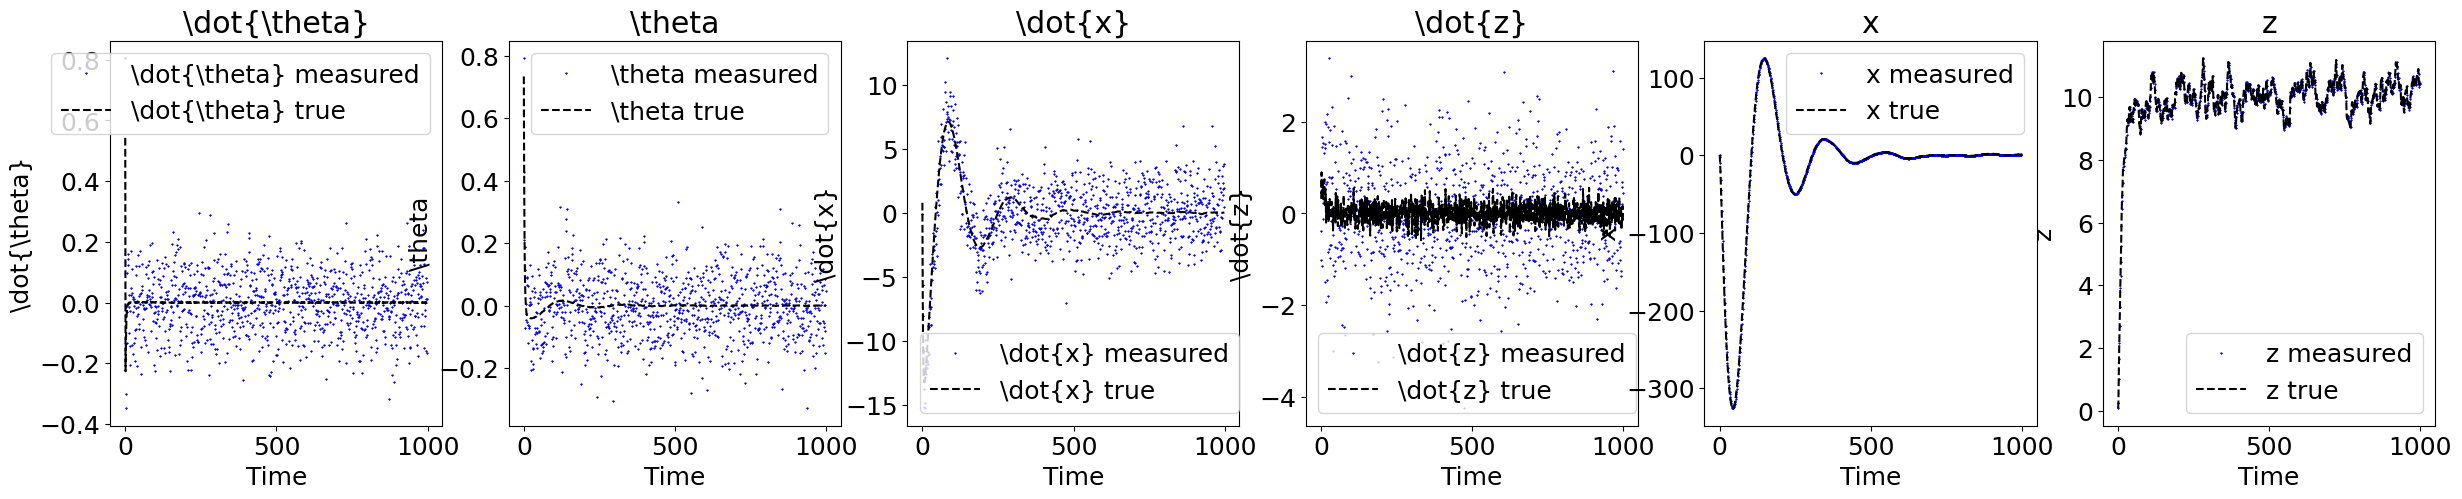

In [85]:
# fig, axes = plt.subplots(1, 4, figsize=(15, 5))
# axes = (ax for ax in axes.ravel())

# ax = next(axes)
# plot_tme(time, true_yvals[:,0], noisy_yvals[:,0], ax=ax, label_var='theta_dot')

# ax = next(axes)
# plot_tme(time, true_yvals[:,1], noisy_yvals[:,1], ax=ax, label_var='theta')

# ax = next(axes)
# plot_tme(time, true_yvals[:,2], noisy_yvals[:,2], ax=ax, label_var='xdot')

# ax = next(axes)
# plot_tme(time, true_yvals[:,3], noisy_yvals[:,3], ax=ax, label_var='zdot')

figcol = len(h_to_use)
fig, axes = plt.subplots(1, figcol, figsize=(5*figcol, 5))
axes = (ax for ax in axes.ravel())
mm = len(h_to_use) if h_to_use != h0 else len(h_to_use)-2
for i, h in enumerate(h_to_use[:mm]):
    ax = next(axes)
    plot_tme(time, true_yvals[:,i], noisy_yvals[:,i], ax=ax, label_var=f'{h_to_use[i]}')
    ax.set_title(f'{h_to_use[i]}')

if h_to_use == h0:
    ax = next(axes)
    plot_tme(time, drone.I*np.ones_like(noisy_yvals[:,0]), noisy_yvals[:,-2], ax=ax, label_var='I')
    ax.set_title('I')

    ax = next(axes)
    plot_tme(time, drone.m*np.ones_like(noisy_yvals[:,0]), noisy_yvals[:,-1], ax=ax, label_var='m')
    ax.set_title('m')

h_to_use

### initial conditions

In [86]:
x0 = np.atleast_2d(np.random.random(len(state))).T
P0 = 10*np.eye(len(state))

R = np.diag(np.array(v[:len(h_to_use)]))

Q = 5e-6*np.eye(len(state))


now we have to define our predicted model and measurement function. kalman filter will try to estimate the states of the model given this model dynamics and measurement function.

In [87]:
model = MyModel(h_to_use, state, dt)

xhat, P, s = ekf.ekf(noisy_yvals.T, x0, model.fd, model.hd, Q, R, sys_input, P0)

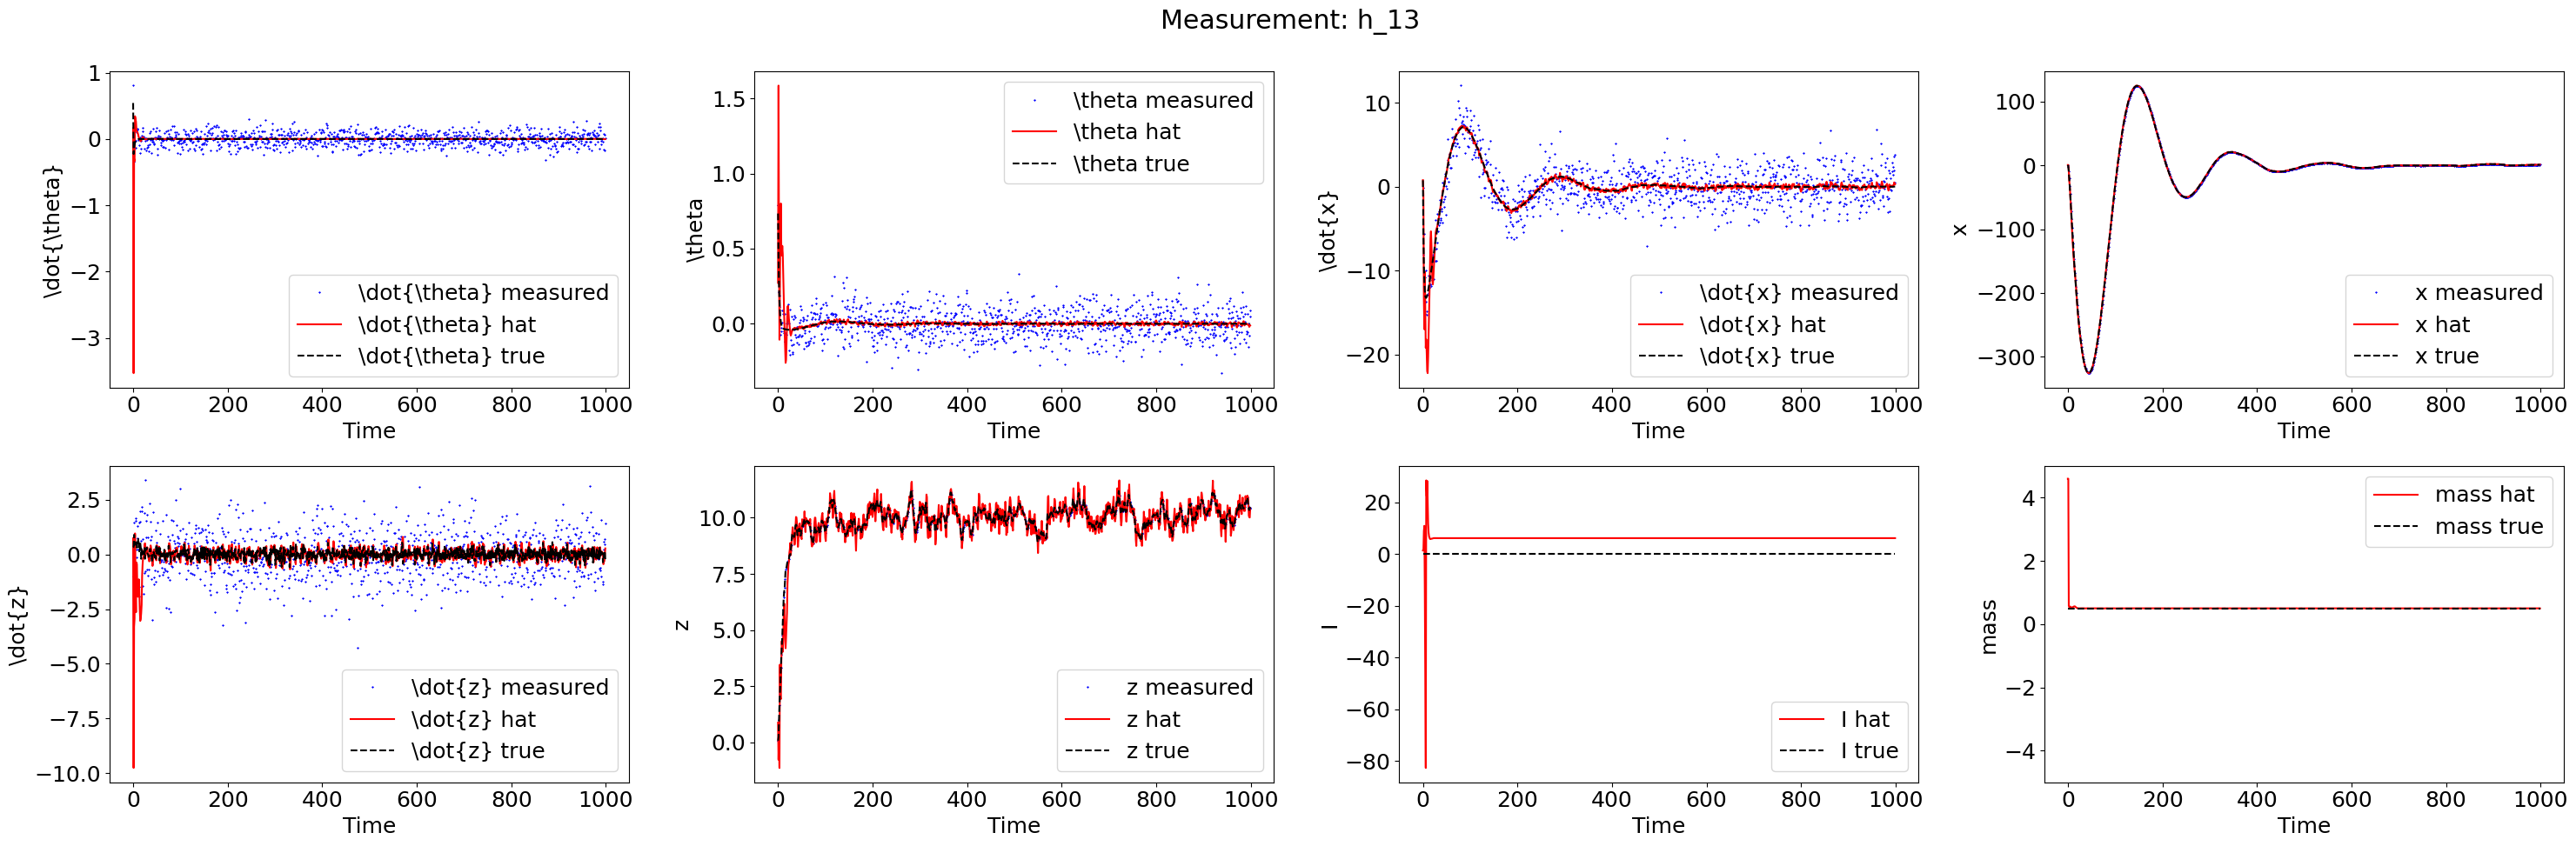

In [88]:
fig, axes = plt.subplots(2, len(state)//2 , figsize=(30, 10))
axes = (ax for ax in axes.ravel())


for i, state_var in enumerate(state[:-2]):
    ax = next(axes)
    # ax.plot(time, true_xvals[:, i], label=f"true {state_var}")
    # ax.plot(time, xhat[i], label=f"estimated {state_var}")
    ind = []
    for ii, _h1 in enumerate(h_to_use):
        if _h1 == state_var:
            ind.append(ii)
            # print(_h1, state_var, ii)
    if len(ind) > 0:
        ind = ind[0]
        plot_tme(time, true_xvals[:, i], noisy_yvals[:, ind], estimated=xhat[i], ax=ax, label_var=f"{state_var}")
    else:
        plot_tme(time, true_xvals[:, i], None, estimated=xhat[i], ax=ax, label_var=f"{state_var}")
    ax.set_ylabel(state_var)
    ax.set_xlabel('Time')
    ax.legend()

ax = next(axes)
plot_tme(time, drone.I*np.ones_like(time), None, 1/xhat[-2], ax=ax, label_var='I')
# ax.set_ylim(-1,1)
# ax.set_yscale('log')

ax = next(axes)
plot_tme(time, 0.5*np.ones_like(time), None, 1/xhat[-1], ax=ax, label_var='mass')
ax.set_ylim(-5,5)

fig.suptitle(f"Measurement: h_{h_collection.index(h_to_use)}")
fig.tight_layout()
fig.savefig(f'../write_ups/figures/ekf_with_{trajectory_name}_and_h{h_collection.index(h_to_use)}.png', dpi=300)

# UKF

In [64]:
import ukf_sqrt

In [145]:
model = MyModel(h_to_use, state, dt)

xhat_ukf, P_ukf, s_ukf = ukf_sqrt.ukf_sqrt(noisy_yvals.T, x0, model.fd, model.hd, Q, R, sys_input, None)

/home/beast/toha/Nonlinear_and_Data_Driven_Estimation/.venv/lib/python3.10/site-packages/ukf_sqrt/utils.py:66: RuntimeWarning: divide by zero encountered in divide
  A2[k, k + 1:] = (A2[k, k + 1:] + sign * s * x[k + 1:]) / c
/home/beast/toha/Nonlinear_and_Data_Driven_Estimation/.venv/lib/python3.10/site-packages/ukf_sqrt/utils.py:67: RuntimeWarning: invalid value encountered in multiply
  x[k + 1:] = c * x[k + 1:] - s * A2[k, k + 1:]
/home/beast/toha/Nonlinear_and_Data_Driven_Estimation/.venv/lib/python3.10/site-packages/ukf_sqrt/utils.py:63: RuntimeWarning: invalid value encountered in scalar divide
  c = r / A2[k, k]
/home/beast/toha/Nonlinear_and_Data_Driven_Estimation/.venv/lib/python3.10/site-packages/ukf_sqrt/utils.py:64: RuntimeWarning: divide by zero encountered in scalar divide
  s = x[k] / A2[k, k]
/home/beast/toha/Nonlinear_and_Data_Driven_Estimation/.venv/lib/python3.10/site-packages/ukf_sqrt/utils.py:66: RuntimeWarning: invalid value encountered in add
  A2[k, k + 1:] = (A

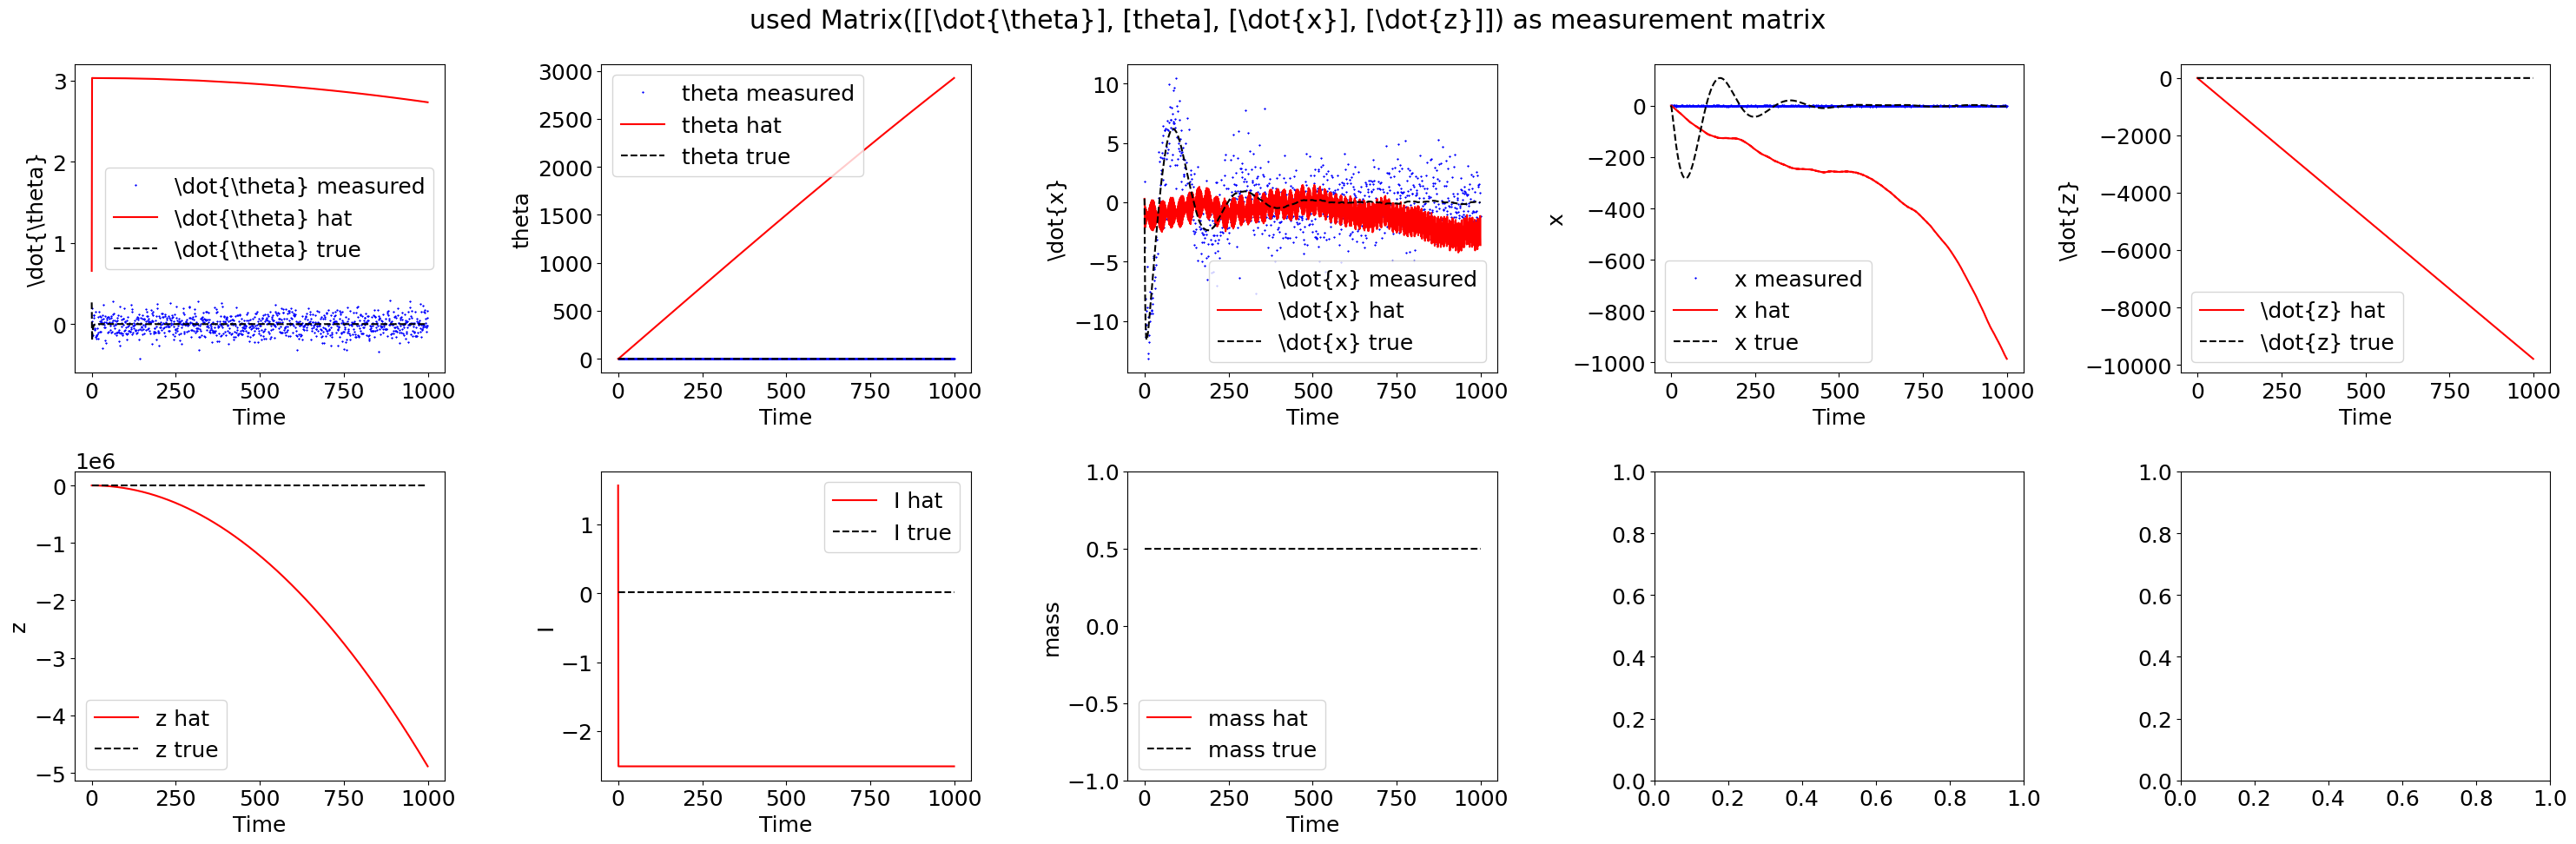

In [146]:
fig, axes = plt.subplots(2, len(state)//2 + 1, figsize=(30, 10))
axes = (ax for ax in axes.ravel())


for i, state_var in enumerate(state[:-2]):
    ax = next(axes)
    # ax.plot(time, true_xvals[:, i], label=f"true {state_var}")
    # ax.plot(time, xhat[i], label=f"estimated {state_var}")
    try:
        plot_tme(time, true_xvals[:, i], noisy_yvals[:, i], estimated=xhat_ukf[i], ax=ax, label_var=f"{state_var}")
    except:
        plot_tme(time, true_xvals[:, i], None, estimated=xhat_ukf[i], ax=ax, label_var=f"{state_var}")
    ax.set_ylabel(state_var)
    ax.set_xlabel('Time')
    ax.legend()

ax = next(axes)
plot_tme(time, drone.I*np.ones_like(time), None, 1/xhat_ukf[-2], ax=ax, label_var='I')
# ax.set_ylim(-1,1)
# ax.set_yscale('log')

ax = next(axes)
plot_tme(time, 0.5*np.ones_like(time), None, 1/xhat_ukf[-1], ax=ax, label_var='mass')
ax.set_ylim(-1,1)

fig.suptitle(f"used {h_to_use} as measurement matrix")
fig.tight_layout()

# model predictive control